In [1]:
# standard ds imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for statistical analysis
import scipy.stats as stats

# for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for wrangling
import wrangle
import explore
import evaluate

# for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

# for feature selection verification and evaluation 
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# filter out noise
import warnings
warnings.filterwarnings('ignore')

# align markdown tables to the left

In [2]:
%%html
<style>
table {float:left}
</style>

# Zillow Regression Project

This project is designed to identify key features and build a regression model to best predict a home's tax assessed value. This report will interchagably use 'cost' or 'value' to refer to a home's tax assessed value.  

-----

## Executvie Summary:

Goals:
- Identify factors evaluated in home value
- Build a model to best predict home value
- Minimize Root Square Mean Error (RMSE) in modeling

Key Findings:
- Location data and use of home square-footage is the most impactful for predicting home value. 
- Adding a bathroom increases home value more than adding a bedroom. 
- All models (LarLasso, Quadratic Linear Regression, Cubic Linear Regression) predicted home value better than the baseline.

Takeaways:
 - My best model, Quadratic Linear Regression, only reduced the baseline error by \\$35,000 or 13% of total baseline error. 
 - More in home features and/or quality of life by location data would greatly improve the model. 

Recommendations:
- Evaluate data that tax value assessors use in their assessment. They have a policy and procedure they must follow, and being able to use their process in predicting home value would be essential to building better models moving forward.

----

## 1. Planning

 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
 - Build functional wrangle.py, explore.py, and model.py files
 - Acquire the data from the Code Up database via the wrangle.acquire functions
 - Prepare and split the data via the wrangle.prepare functions
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Create a baseline model in predicting home cost and document the RSME.
 - Fit and train three (3) regression models to predict cost on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps. 

-----

## 2. Data Acquisition
In this step, I called my acquire_zillow function from wrangle.py. This function:
- grabs the data from the CodeUp database via a SQL query
- creates a local CSV of the table, if not already saved locally

#### Data Dictionary

| Target | Type | Description |
| ---- | ---- | ---- |
| value | int | The assessed tax value amount of the home |


| Feature Name | Type | Description |
| ---- | ---- | ---- |
| area | float | Sum of square feet in the home |
| baths | float | Count of bathrooms in the home |
| beds | float | Count of bedrooms in the home |
| decade | int | The decade the home was built in |
| extras | float | Sum of the home's bathrooms, bedrooms, stories, pool, and if it has a garage |
| garage | int | Sum of square feet in the garage |
| half_bath | int | 1 if the home has a half bath, 0 if not |
| lat | float | The home's geographical latitude |
| lat_long | float | The home's latitude divided by its longitude |
| living_space | float | The home area in sqft minus 132sqft per bedroom and 40sqft per bathroom (average sqft per respective room) |
| location | object | The human-readable county name the home is in |
| long | float | The home's geographical longitude |
| los_angeles | int | 1 if the home is in Los Angeles County, 0 if not | 
| lot_size | float | Sum of square feet of the piece of land the home is on |
| orange | int | 1 if the home is in Orange County, 0 if not |
| pool | int | 1 if the home has a pool, 0 if not |
| stories | int | Count of how many levels or stories the home has |
| ventura | int | 1 if the home is in Ventura County, 0 if not|
| yard_size | float | The lot size minus the home area in sqft |
| year_built | float | The year the home was built |
| zipcode | float | The US postal service 5-digit code for the home's location |

In [3]:
# Acquire the data
zillow_data = wrangle.acquire_zillow()

In [4]:
# Look at the shape to ensure we got what we wanted
zillow_data.shape

(52441, 13)

### Acquisition Takeaways
- The zillow data brings in 10 columns of data covering 52,441 homes. 
- These homes had transactions during 2017 and are tagged as Single Family Residences.

----

## 3. Data Preparation
In this step, I called prepare_zillow from wrangle.py. This function:
- renames columns
- handles nulls and outliers
- feature engineers
- splits the data into train, validate, and test datasets
- creates a scaled DataFrame pre-set for modeling later

More specifically:
- columns are renamed to be more human readable
- drops all homes with missing data
- creates dummies for the counties (Los Angeles, Orange, and Ventura)
- removes outliers for lot_size, value, and area using quantiles
- removes a single zipcode outlier
- feature engineers:
    - decade -> bins year_built into 10 year segments
    - yard_size -> subtracts home area from the lot size
    - living_space -> subtract the average bedroom size and bathroom size from the home area
    - half_bath -> creates a True/False (1/0) tag for homes with a half bathroom

In [5]:
# Prepare the data
zillow_data = wrangle.prepare_zillow(zillow_data)

In [6]:
# Split the data into dataset. 60% for train, 20% for validate, and 20% for test
train, val, test = wrangle.split_data(zillow_data)

In [7]:
# Set the features to be scaled.
cols_to_scale = ['beds', 'baths', 'area', 'lot_size', 'year_built', 
                 'zipcode', 'lat', 'long', 'pool', 'stories', 'garage_sqft',
                 'yard_size', 'living_space', 'half_bath', 'lat_long', 'extras'
                ]
# Scaled the data and assigns it to new DataFrames
train_scaled, val_scaled, test_scaled = wrangle.scale_data(train, val, test, cols_to_scale)

### Preparation Takeaways
- I feature engineered yard_size and living_space to better assess the aspect ratio of these features. More yard or living area may play a role in home value. 
- I feature engineered decades for the purpose of visualization during explore
- I feature engineered half_bath to isolate homes with this feature. 
- Before moving to exploration, I split the data into train, validate, and test datasets. Lastly, I created scaled versions of these datasets in preparation for modeling.

----

## 4. Data Exploration

### Question 1: Do larger homes have more value?

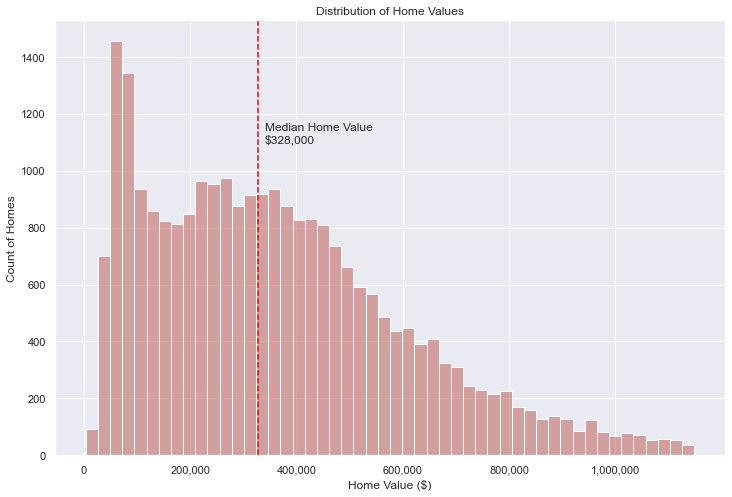

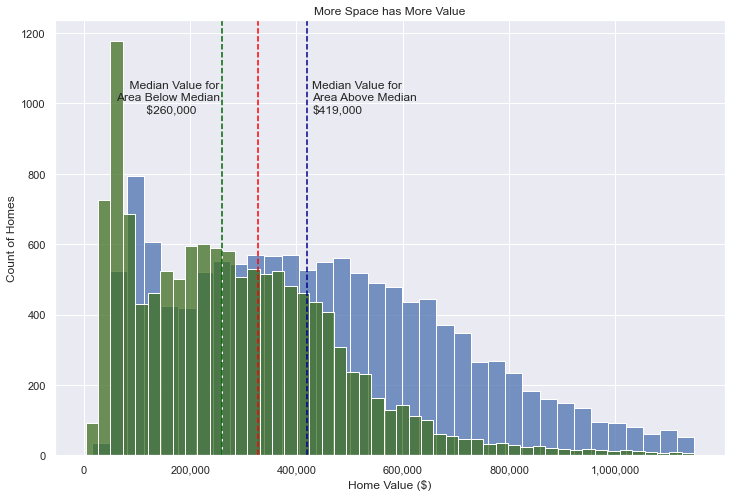

In [8]:
# Show the visualizations for this questions
explore.question1_viz(train)

#### Hypothesis 1:
- Ho1 -> Homes with above median area have less than or equal value to homes with below median area
- Ha1 -> Homes with above median area have greater value to homes with below median area

T-Test: Two-Sample, One-Tail

In [9]:
# Run the test for this question
explore.hyp1_test(train)

Reject the Null Hypothesis.
        
Findings suggest there is more value in homes with above median area than homes with below median area.


#### Question 1 Takeaways:
- There is more value in homes with above median area.

----

### Question 2: Is there more value in bedrooms or bathrooms?

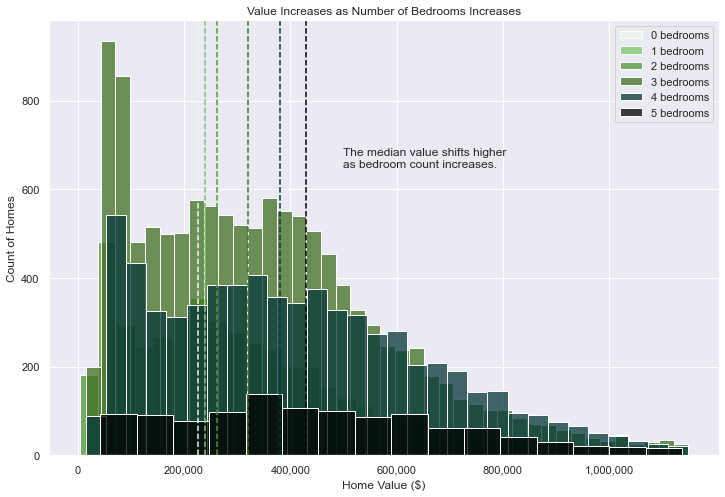

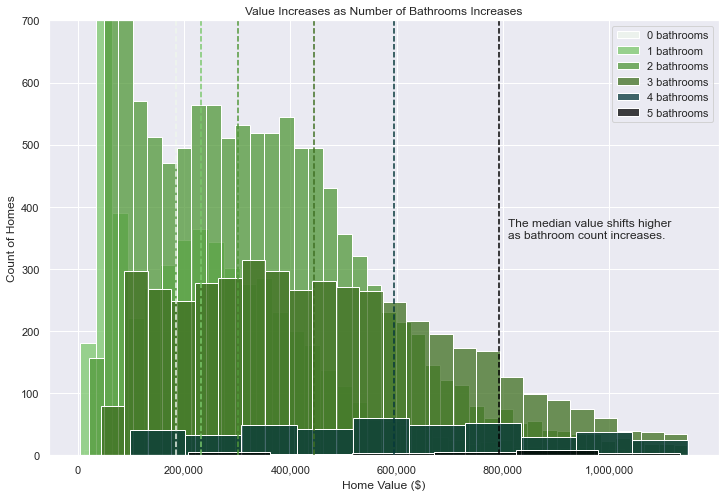

In [10]:
# Show the visualizations for this question
explore.question2_viz(train)

#### Hypothesis 2: 
- Ho2 -> Homes with above median bathrooms and below median bedrooms have a lower or equal value than homes with below median bathrooms and above median bedrooms.
- Ha2 -> Homes with above median bathrooms and below median bedrooms have a greater value than homes with below median bathrooms and above median bedrooms.

T-Test: Two-Sample, One-Tail

In [11]:
# Run the test for this question
explore.hyp2_test(train)

Reject the Null Hypothesis.
        
Findings suggest there is more value in homes with above median bathrooms and below median bedrooms than homes with below median bathrooms and above median bedrooms.


### Question 2b: Is the number of bathrooms and bedrooms related?

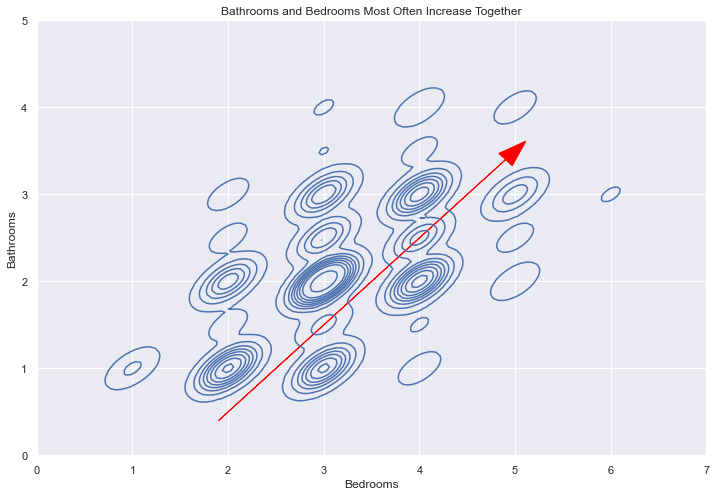

In [12]:
# Show the visualizations for this question
explore.question2b_viz(train)

#### Hypothesis 2b:
- Ho2b -> There is not an association between bedrooms and bathrooms.
- Ha2b -> There is an association between bedrooms and bathrooms.

Chi-Square Test: Bedrooms vs Bathrooms

In [13]:
# Run the test for this hypothesis
explore.hyp2b_test(train)

Reject the Null Hypothesis.
        
Findings suggest there is an association between bedrooms and bathrooms.


#### Question 2 Takeaways:
- There is more value in homes with above median bathrooms and below median bedrooms than the opposite. 
- There is an association between bedrooms and bathrooms.

----

### Question 3: What is location's role in home value?

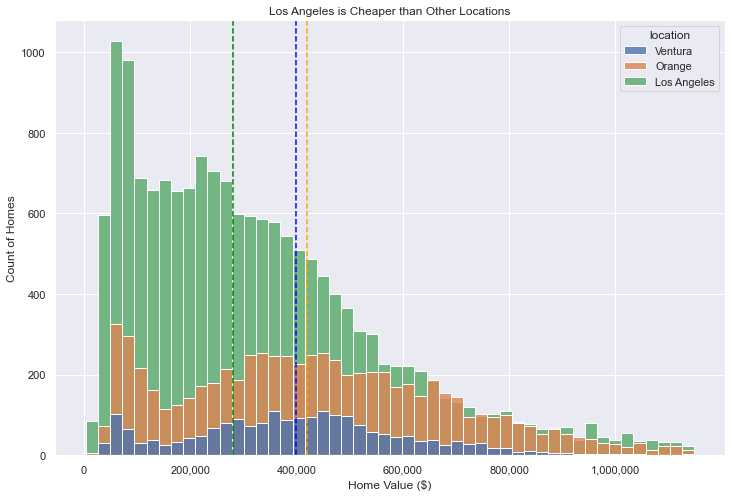

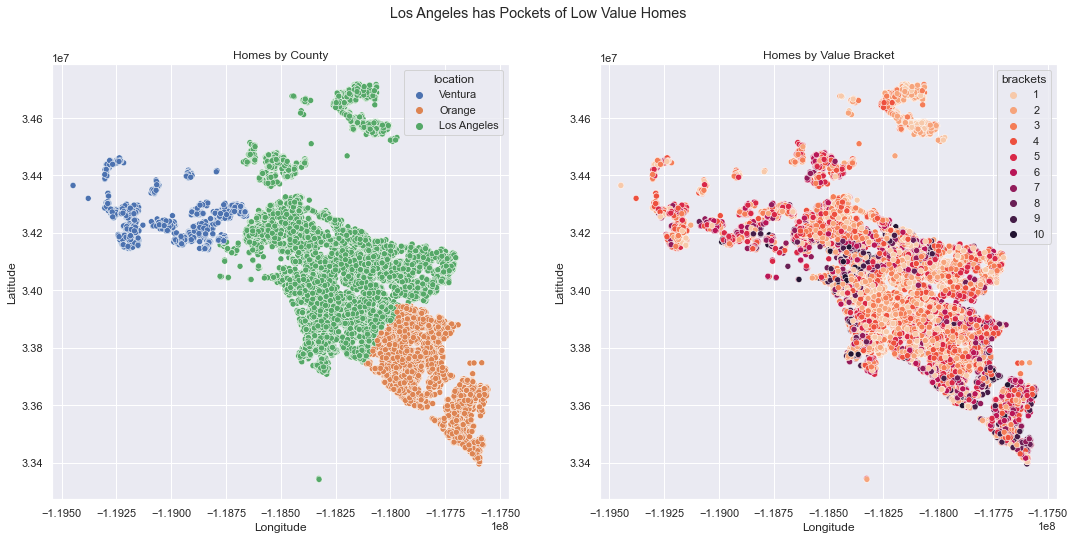

In [14]:
# Show the visualizations for this question
explore.question3_viz(train)

#### Hypothesis 3:
- Ho3 -> The value mean of Los Angeles homes is greater than or equal to the value mean of Ventura and Orange homes.
- Ha3 -> The value mean of Los Angeles homes is less than the value mean of Ventura and Orange homes.

T-Test: Two-Sample, One-Tail

In [15]:
# Run the test for this hypothesis
explore.hyp3_test(train)

Reject the Null Hypothesis.
        
Findings suggest there is less value in Los Angeles homes than homes in Ventura or Orange.


#### Question 3 Takeaways:
- There is less value in Los Angeles homes than in Orange or Ventura.

-----

### Explore Takeaways:
- There is more value in homes with above median area.
- There is more value in homes with above median bathrooms and below median bedrooms than the opposite. 
- There is an association between bedrooms and bathrooms.
- There is less value in Los Angeles homes than in Orange or Ventura.

----

## 5. Data Modeling

Select features were dropped in order to maximize model fitting based on all findings. It is highly apparent location metrics play a key role in determining assessed home value. The location feature that was dropped below was split out to be los_angeles, orange, and ventura features in order to prevent skew in modeling. 

| Features Kept | Features Dropped |
| ---- | ---- |
| baths | location |
| beds | decade |
| area | yard_space |
| lot_size |  |
| zipcode |  |
| lat |  |
| long |  |
| lat_long |  |
| los_angeles |  |
| orange |  |
| ventura |  |
| living_space |  |
| half_bath |  |
| pool |  |
| stories |  |
| garage |  |
| extras |  |

#### My goal is to minimize RMSE while maintaining a healthy R<sup>2</sup> in order to minimize error while still being able to account for it.

In [16]:
# Create the X and y for train, validate, and test
# Get it ready for modeling
X_train, y_train, X_val, y_val, X_test, y_test = evaluate.model_setup(train_scaled, train, val_scaled, val, test_scaled, test)

In [17]:
# Get the modeling results
metrics = evaluate.get_models_with_results(X_train, y_train, X_val, y_val)
metrics

,model,rmse_train,r2_train,rmse_val,r2_val
0,baseline_mean,239723.095901,0.000000,235783.988648,0.000000
1,"LarsLasso, alpha 1",206633.994875,0.257009,203880.552917,0.252447
2,Quadratic Linear Regression,198529.006078,0.314152,196592.434326,0.305107
3,Cubic Linear Regression,190496.922832,0.368525,194693.024743,0.318379


### Modeling Takeaways:
- The quadratic linear regression model performed best with \\$196,592 RMSE and a .305 R<sup>2</sup> value.
- The cubic linear regression model appears to be overfit.
- All three models out performed the baseline by at least \\$30,000.
- Despite beating baseline, none of these models are able to predict home value with a high degree of certainty. 
- Going forward I would look into other machine learning methods to create a better fit model.

----

## Model Evaluation

Evaluate the best model with the test dataset

In [18]:
# Test the best model
best = evaluate.run_best_test(X_train, y_train, X_val, y_val, X_test, y_test)
best.T

,rmse,r2
train,198529.006078,0.314152
validate,196592.434326,0.305107
test,203822.225140,0.295349


----

## Conclusion
Home value is assessed through a myraid of metrics taken about the home. Location and area based information have proven the most valuable, but there is still room for improvement. My best model only reduced the root mean squared error by \\$35,000 from the baseline results; a 13% reduction in error.

### Recommendations:
- Evaluate data that tax value assessors use in their assessment. They have a policy and procedure they must follow, and being able to use their process in predicting home value would be essential to building better models moving forward.
- Add data or begin tracking school rankings and crime rates for each neighborhood. I predict sections of homes with higher school ratings and low crime rates will value for more than homes with low school ratings or high crime rates.

### Next Steps:
- Feature engineer more detailed depictions of the use of the area inside the home. Specifically determine the kitchen vs living area sections of the home and see how this effects the model.
- Develop a model using different machine learning techniques focused on geographical distance. Home value is often geographically clusered as depicted in our finidngs. 
----